In [1]:
#install.packages("dplyr")
#install.packages("ggplot2") 
#install.packages("lmtest")
library("dplyr")
library("ggplot2")  
library("lmtest")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [148]:
# Adicionando o diretorio atual
setwd("../");

# Lendo os dados
dataset <- read.csv(file="./base_traduzida.csv", header=TRUE, sep=",")
base <- subset (as.data.frame(dataset), select = -c(X))

# Nomes mais curtos
short_names <- c("Preço", "Núm. Vendas", "Nota", "Núm. Notas", "Preço Varejo", "Nota Vendedor", "Notas Vendedor")

Warning message in file(file, "rt"):
“cannot open file './base_traduzida.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [239]:
## Seçao de outliers
# Quartis
Q1 = 0.25
Q2 = 0.5
Q3 = 0.75
Q4 = 1.0

# Calcula Inter Quartile Range (IQR) da lista
iqrange <- function(arr)
{
    quantile(arr, Q3) - quantile(arr, Q1)
}

# Limpa outliers se baseando em uma coluna
limpaOutlier <- function(df, col)
{
    IQR = iqrange(unlist(df[[col]]))
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    subset(df, df[[col]] > lower & df[[col]] < upper)
}

limpaOutlierGeral <- function(df)
{
    names = colnames(base)
    for(i in 1:(length(names)))
    {
        df = limpaOutlier(df, names[i])
    }
    df
}

# Bem especifico
limpaOutlierSpecifico <- function(base_2)
{
    
    base_2 = limpaOutlier(base_2, "Preço_do_Produto")
    base_2 = limpaOutlier(base_2, "Unidades_Vendidas")
    base_2 = limpaOutlier(base_2, "Quantidade_de_Avaliações")
    base_2 = limpaOutlier(base_2, "Preço_de_Varejo")
    base_2 = limpaOutlier(base_2, "Quantidade_de_Avaliações_do_Vendedor")
    base_2
}

In [140]:
## Graficos e transformacoes auxiliares

# Aplicacao cartesiana de vetores de nomes e dados sobre a funcao func, retorna um data frame "matricial" linear
crossDataFrame <- function(arra, arrb, data_a, data_b, func_a, func_b)
{
    x = 1:(length(arra)*length(arrb))
    y = 1:(length(arra)*length(arrb))
    z = 1:(length(arra)*length(arrb))
    k = 1:(length(arra)*length(arrb))
    
    for(i in 1:length(arra))
    {
        for(j in 1:length(arrb))
        {
            x[(i-1)*length(arra) + j] = arra[i]
            y[(i-1)*length(arra) + j] = arrb[j]
            z[(i-1)*length(arra) + j] = func_a(data_a[i], data_b[j])
            k[(i-1)*length(arra) + j] = func_b(data_a[i], data_b[j])
        }
    }
    
    data.frame(x=x, y=y, z=z, k=k)
}

# Aplicacao linear de uma funcao sobre um vetor, retorna um data frame linear
linearDataFrame <- function(names_a, arr, func_a, func_b)
{
    y = 1:(length(names_a))
    z = 1:(length(names_a))
    
    for(i in 1:length(names_a))
    {
        y[i] = func_a(arr[i])
        z[i] = func_b(arr[i])
    }
    
    data.frame(x=names_a, y=y, z=z)
}

# Transforma um dataframe em um vetor de colunas, sim
dfArrayCols <- function(df)
{
    x = vector(mode = "list", length = ncol(df)) 
    for(i in 1:ncol(df))
    {
        x[i] = list(df[,i])
    }
    x
}

# Gera mapa de calor sobre um dataframe (x, y, z, k)
# e a configuracao de cores
heatMap <- function(map, scale_lab="")
{
    heat <- ggplot(map, aes(x, y)) + geom_tile(aes(fill = z))
    heat = heat + scale_fill_gradient(low = "#0000FF", high = "#EE6600", name=scale_lab) + theme(axis.title.y=element_blank(), axis.title.x=element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=16, face="bold"), axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    heat + geom_text(aes(label=k))
}

# Retorna um a "cor" de um p-value
pvalueColors<- function(v)
{
    color <- "#000000"
    
    if(v > -log(0.01, 10)) 
        color = "#DD0000"
    else if(-log(0.01, 10) >= v && v > -log(0.05, 10))
        color = "#FFFF00"
    else if(-log(0.05, 10) >= v && v > -log(0.1, 10))
        color = "#00AA22"
    else if(-log(0.1, 10) >= v)
        color = "#00FF00"
    color
}

# Gera um barplot sobre um dataframe(x=dados eixo x, y= dados eixo y, z=labels)
barPlot <- function(df, title="", xlab="", ylab="")
{
    bp <- ggplot(data=df, aes(x=x, y=y)) + geom_bar(stat="identity", fill=df$colors)
    bp = bp + labs(title=title, x=xlab, y = ylab)
    bp = bp + geom_text(aes(label=z), vjust=1.6, color="black", size=5) + theme_grey(base_size = 18)
    bp = bp + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    bp = bp + theme(plot.background = element_rect(fill = "white"), 
                    panel.background = element_rect(fill = "#DDDDDD"), 
                    axis.line.x = element_line(color = "black"), 
                    axis.line.y = element_line(color = "black"))
}

# Gera um barplot sobre um dataframe(x=dados eixo x, y= dados eixo y)
# especifico para pvalues
pvaluePlot <- function(df, title="", xlab="", ylab="")
{
    df$colors = unlist(lapply(df$y, pvalueColors))
    bp <- barPlot(df, title, xlab, ylab) + geom_hline(yintercept = -log(0.05, 10), col="black")
    bp
}
  
# Gera um grafico de dispersao, base = dataframe, x=nome coluna x, y=nome coluna y, _names sao os nomes nos eixos
geraScatterPlot <- function(base, x, y, title="", xcol_name="", ycol_name="")
{
    plot = ggplot(base, aes(x=base[[x]], y=base[[y]])) + geom_point()
    plot = plot + theme(axis.title.y=element_text(size=16, face="bold"), axis.title.x=element_text(size=16, face="bold"))
    plot = plot + labs(title=title,x=xcol_name, y=ycol_name)
    plot = plot + theme(axis.text.x = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    plot = plot + theme(axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
    plot = plot + theme(plot.background = element_rect(fill = "white"), 
                    panel.background = element_rect(fill = "#DDDDDD"), 
                    axis.line.x = element_line(color = "black"), 
                    axis.line.y = element_line(color = "black"))
    plot
}

## Funcoes de apoio
    
# Funcao de string vazio
voidFunc <- function(a, b)
{
    v <- ""
    v
}

$$ 
   f(p) = -\log_{10}(p)
$$

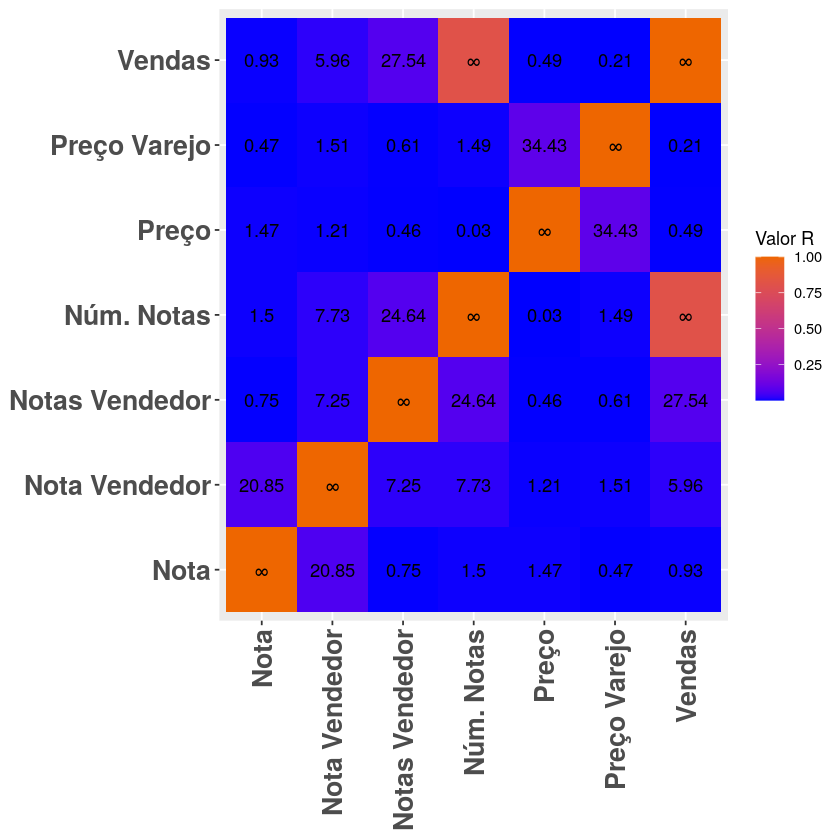

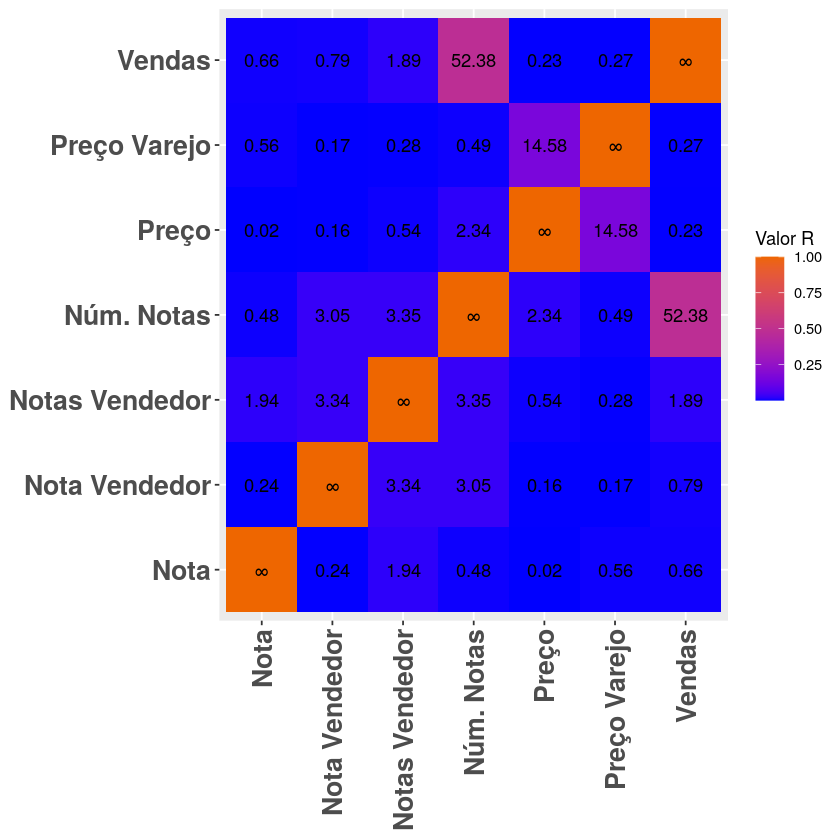

In [256]:
# Pressuposto de linearidade

# Valor R de regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmR <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- summary(lm(a ~ b))$r.squared
    fit = as.numeric(format(fit, digits=1, nsmall=2))
    options(warn=0) #re-abilita avisos
    fit
}

# Valor p de regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmPv <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- summary(lm(a ~ b))$coefficients[2,4]
    options(warn=0) #habilita avisos
    ret <- as.numeric(format(-log(fit, 10), digits=1, nsmall=2))
    if(fit == 0)
        ret = sprintf("\u221E")
    ret
}  

# base = dataframe convertido do csv
geraHeatmapLinearidade <- function(base)
{
    df <- dfArrayCols(base)
    m = crossDataFrame(short_names, short_names, df, df, funcLmR, funcLmPv)
    heatMap(m,  "Valor R") 
}

geraHeatmapLinearidade(base)

base_2 = limpaOutlierSpecifico(base)
geraHeatmapLinearidade(base_2)
#plot(base[["Unidades_Vendidas"]], base[["Quantidade_de_Avaliações"]])

Warning message:
“Use of `base[[x]]` is discouraged. Use `.data[[x]]` instead.”
Warning message:
“Use of `base[[y]]` is discouraged. Use `.data[[y]]` instead.”


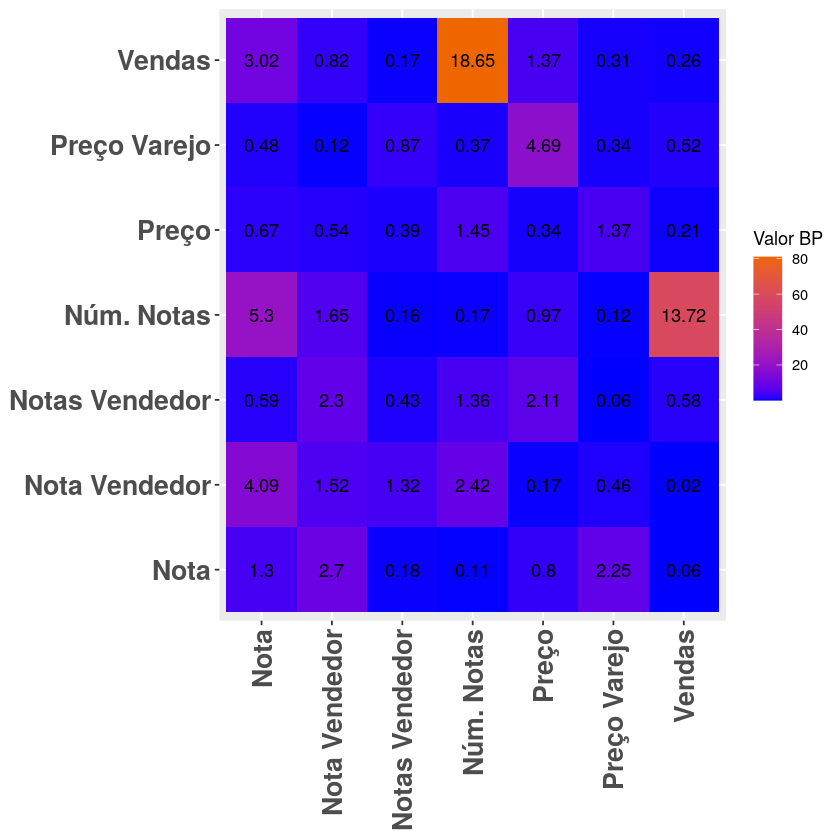

Warning message:
“Use of `base[[x]]` is discouraged. Use `.data[[x]]` instead.”
Warning message:
“Use of `base[[y]]` is discouraged. Use `.data[[y]]` instead.”


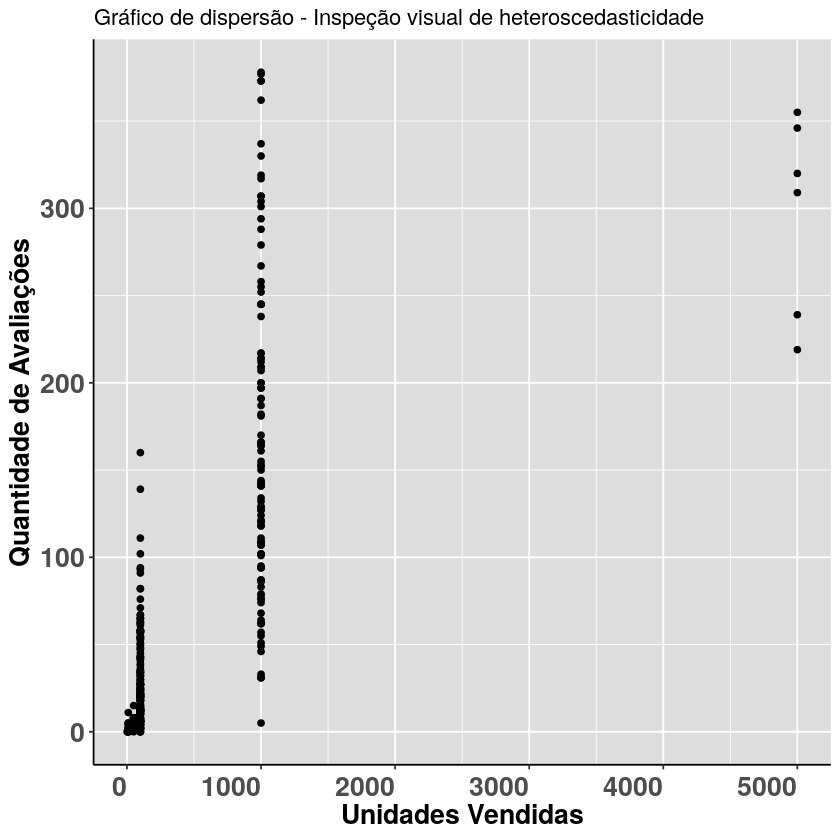

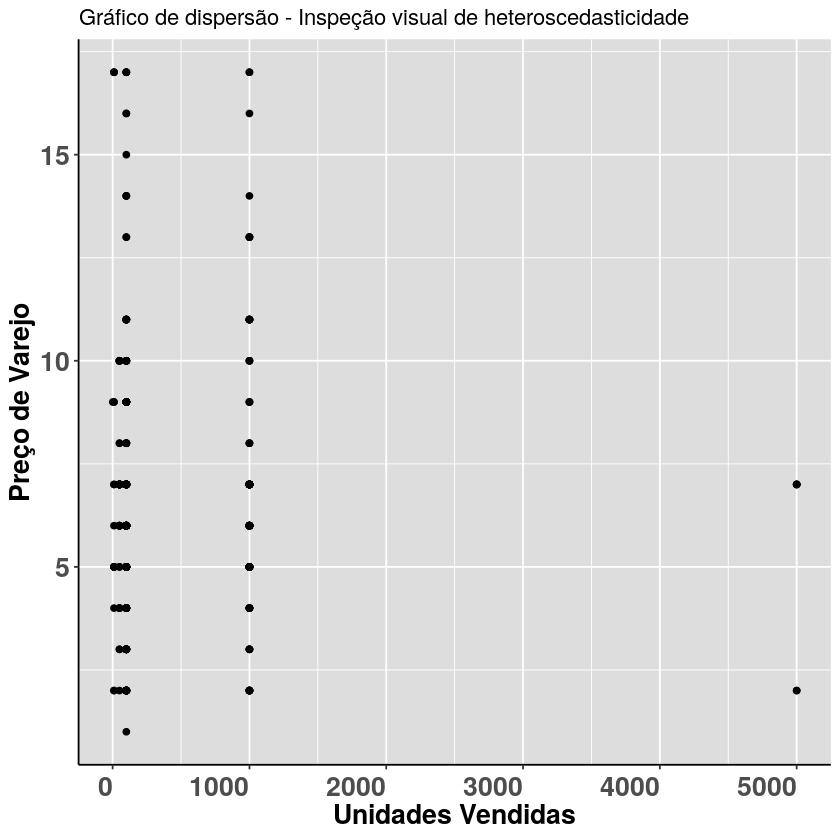

In [246]:
# Pressuposto de heteroscedasticidade.

# Valor BP do teste Breusch-Pagan sobre uma regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmBpBP <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- bptest(lm(a ~ b))$statistic
    fit = as.numeric(format(fit, digits=1, nsmall=2))
    options(warn=0) #re-abilita avisos
    fit
}

# Valor p do teste Breusch-Pagan sobre uma regressao linear simples
# a, b = colunas de um dataframe contendo os dados
funcLmBpPv <- function(a, b)
{
    options(warn=-1) #desabilita avisos
    a = unlist(a)
    b = unlist(b)
    fit <- bptest(lm(a ~ b))$p.value
    options(warn=0) #habilita avisos
    ret <- as.numeric(format(-log(fit, 10), digits=1, nsmall=2))
    if(fit == 0)
        ret = sprintf("\u221E")
    ret
}  

geraHeatmapHeterosc <- function(base)
{
    df <- dfArrayCols(base)
    m = crossDataFrame(short_names, short_names, df, df, funcLmBpBP, funcLmBpPv)
    heatMap(m,  "Valor BP")  
}

#geraHeatmapHeterosc(base)
#geraScatterPlot(base, "Unidades_Vendidas", "Quantidade_de_Avaliações", "Gráfico de dispersão - Inspeção visual de heteroscedasticidade", "Unidades Vendidas", "Quantidade de Avaliações")
#geraScatterPlot(base, "Unidades_Vendidas", "Preço_de_Varejo", "Gráfico de dispersão - Inspeção visual de heteroscedasticidade", "Unidades Vendidas", "Preço de Varejo")

base_2 = limpaOutlierSpecifico(base)
geraHeatmapHeterosc(base_2)
geraScatterPlot(base_2, "Unidades_Vendidas", "Quantidade_de_Avaliações", "Gráfico de dispersão - Inspeção visual de heteroscedasticidade", "Unidades Vendidas", "Quantidade de Avaliações")
geraScatterPlot(base_2, "Unidades_Vendidas", "Preço_de_Varejo", "Gráfico de dispersão - Inspeção visual de heteroscedasticidade", "Unidades Vendidas", "Preço de Varejo")

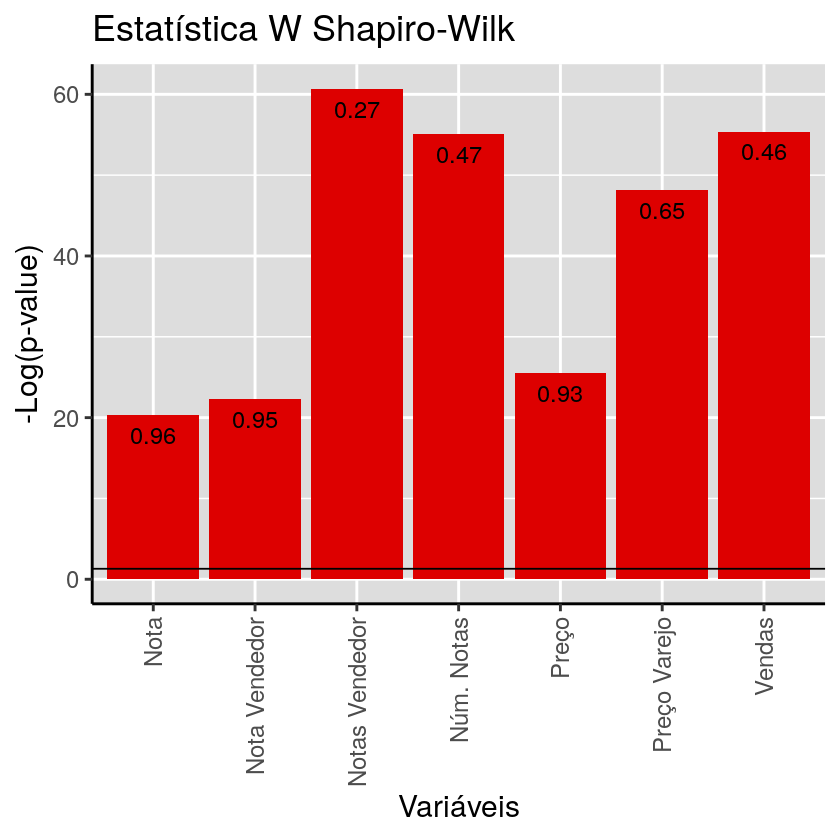

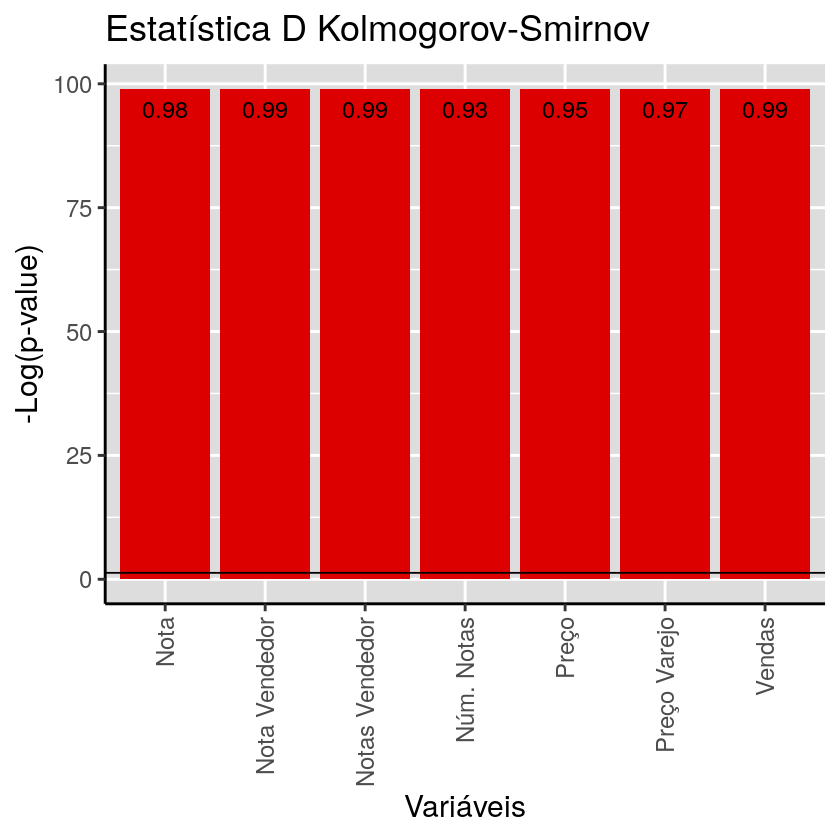

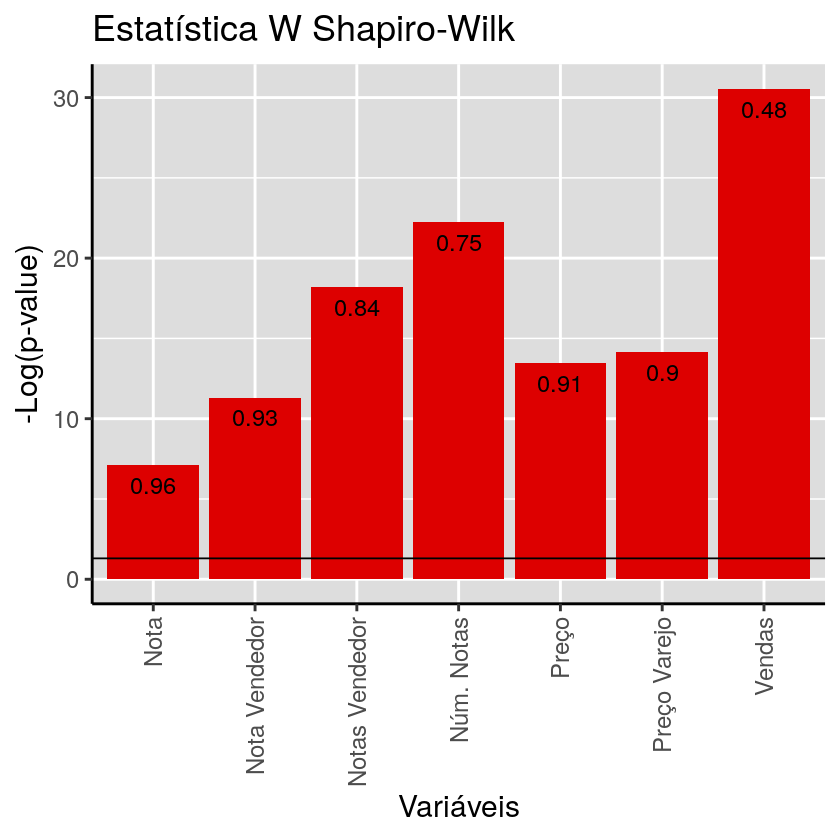

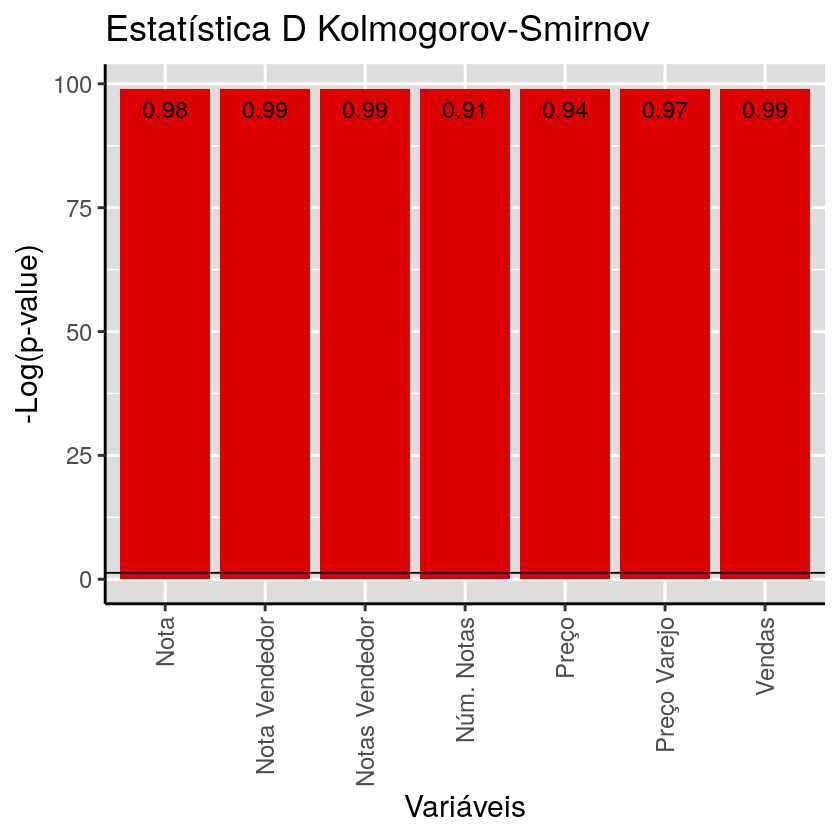

In [241]:
# Pressuposto de normalidade

# Valor W do teste de shapiro-wilk,
# a = coluna de um dataframe contendo os dados
funcShapW <- function(a)
{
    a = unlist(a)
    w <- shapiro.test(a)$statistic
    w = as.numeric(format(w, digits=1, nsmall=2))
    w
}

# Valor p do teste de shapiro-wilk,
# a = coluna de um dataframe contendo os dados
funcShapPv <- function(a)
{
    a = unlist(a)
    p <- shapiro.test(a)$p.value
    ret <- as.numeric(format(-log(p, 10), digits=1, nsmall=2))
    if(p == 0)
        ret = 99 #sprintf("\u221E")
    ret
}

# Isso é uma doença, uma praga, nunca usar isso GG
funcKolmD <- function(a)
{
    a = unlist(a)
    options(warn=-1) #desabilita avisos
    d <- ks.test(a, "pnorm")$statistic
    options(warn=-0) #habilita avisos
    # isso n funciona n sei por que motivos, vsf
    d <- as.numeric(d, digits=1, nsmall=2)
    d
}

# Maior gambiarra da historia da programacao parte 2, eu culpo o proprio R
formatNum <- function(n)
{
    as.double(as.integer(((as.numeric(n, digits=1, nsmall=2)*10000000))/100000))/100
}

funcKolmPv <- function(a)
{
    a = unlist(a)
    options(warn=-1) #desabilita avisos
    p <- ks.test(a, "pnorm")$p.value
    options(warn=-0) #habilita avisos
    ret <- as.numeric(format(-log(p, 10), digits=1, nsmall=2))
    if(p == 0)
        ret = 99 #sprintf("\u221E")
    ret
}

geraBarplotNormalidadeShap <- function(base, col_names=0)
{   
    df <- dfArrayCols(base)
    m = linearDataFrame(col_names, df, funcShapPv, funcShapW)
    pvaluePlot(m, "Estatística W Shapiro-Wilk", "Variáveis", "-Log(p-value)")
}

geraBarplotNormalidadeKolm <- function(base, col_names=0)
{ 
    df <- dfArrayCols(base)
    m = linearDataFrame(col_names, df, funcKolmPv, funcKolmD)
    # Maior gambiarra da historia da programacao parte 1, eu culpo o proprio R
    m$z = unlist(lapply(m$z, formatNum))
    pvaluePlot(m, "Estatística D Kolmogorov-Smirnov", "Variáveis", "-Log(p-value)")
}

geraBarplotNormalidadeShap(base, short_names)
geraBarplotNormalidadeKolm(base, short_names)

base_2 = limpaOutlierSpecifico(base)
geraBarplotNormalidadeShap(base_2, short_names)
geraBarplotNormalidadeKolm(base_2, short_names)

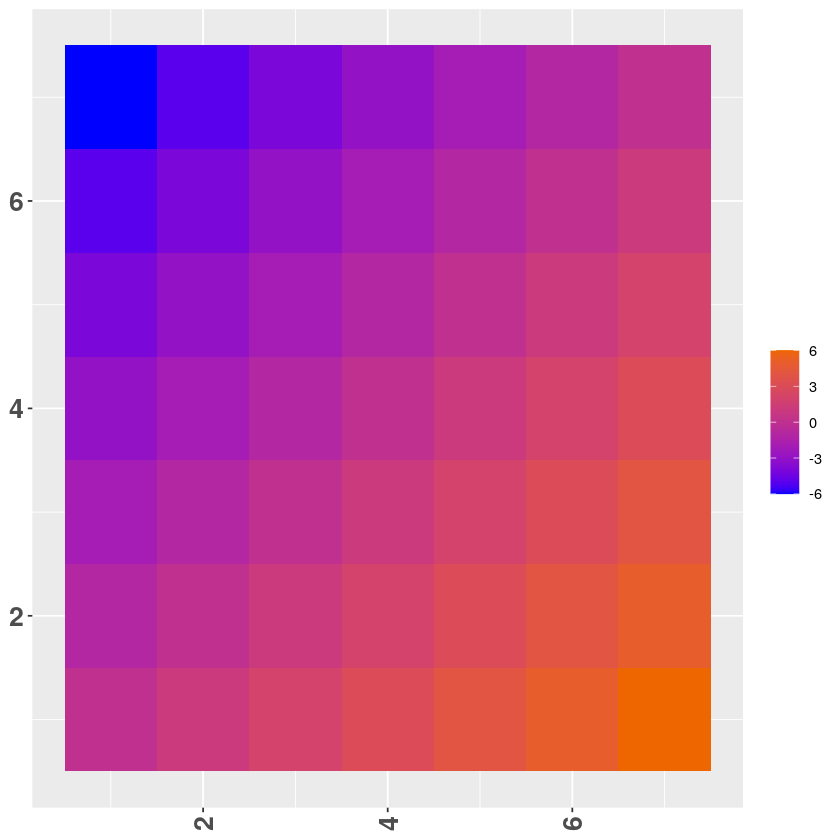

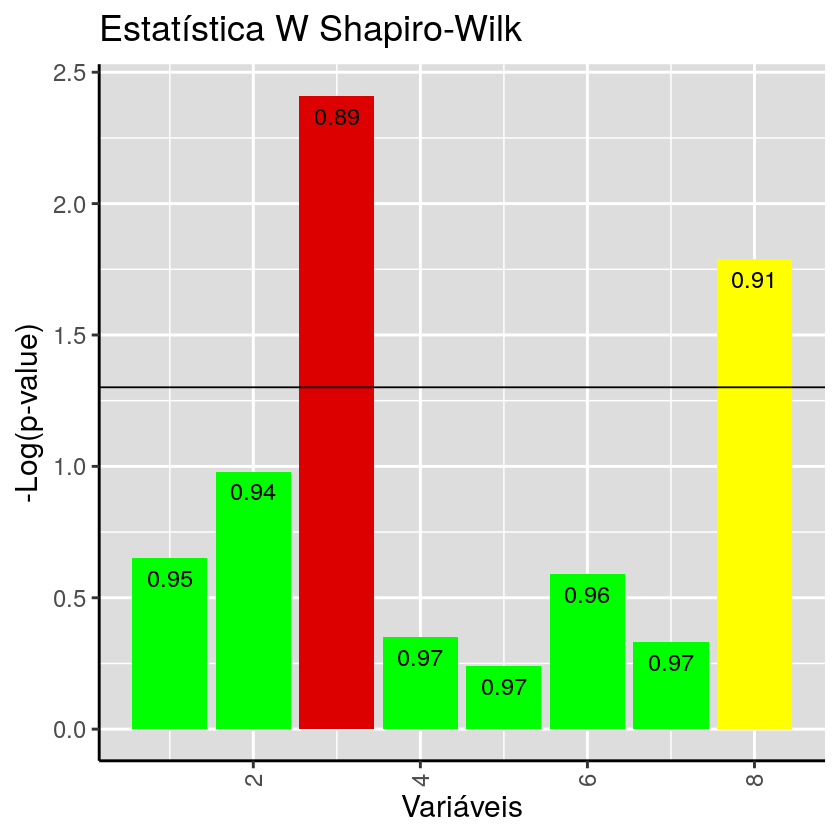

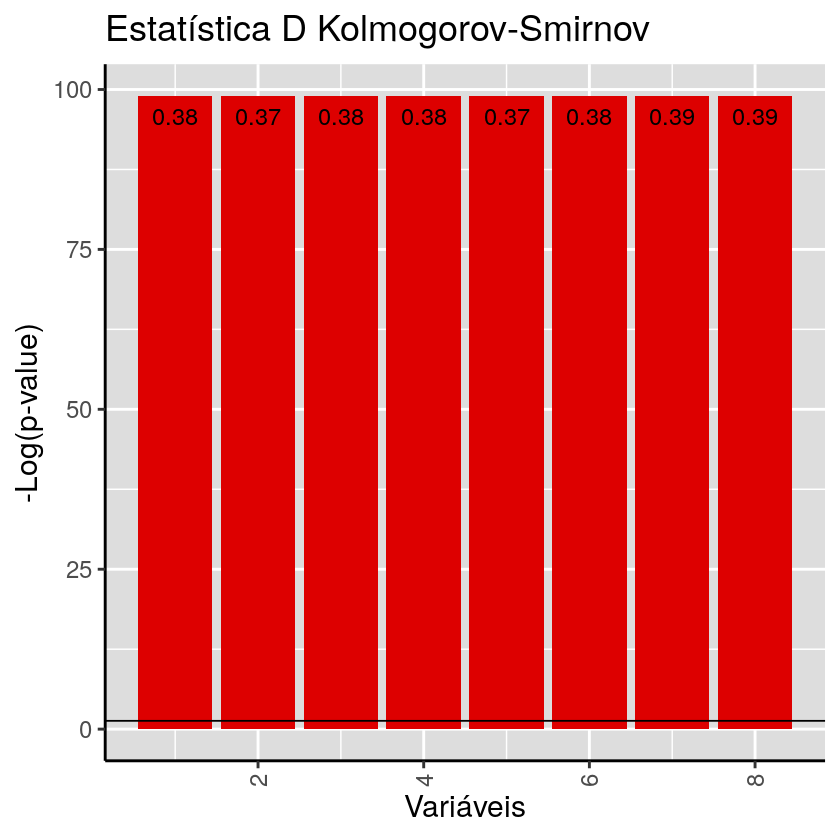

In [273]:
##### Exemplos #####

# Matriz qualquer
func <- function(a, b)
{
   a - b #+ max(a,b) + min(a,b) + runif(1, min(a,b) , max(a,b))
}
m = crossDataFrame(1:ncol(base), 1:ncol(base), 1:ncol(base), 1:ncol(base), func, voidFunc)
heatMap(m) 
    
# Linearidade
df <- dfArrayCols(base)
m = crossDataFrame(short_names, short_names, df, df, funcLmR, funcLmPv)
#heatMap(m,  "Valor R")

# Normalidade
df <- dfArrayCols(base)
m = linearDataFrame(1:ncol(base), df, funcShapPv, funcShapW)
#pvaluePlot(m, "Estatística W Shapiro-Wilk", "Variáveis", "-Log(p-value)")

# Exemplo de barras p-value
base_2 = data.frame(a=rnorm(30, sd=1, mean=1), 
                    b=rnorm(30, sd=1, mean=1), 
                    c=rnorm(30, sd=1, mean=1),
                    d=rnorm(30, sd=1, mean=1),
                    e=rnorm(30, sd=1, mean=1), 
                    f=rnorm(30, sd=1, mean=1), 
                    g=rnorm(30, sd=1, mean=1),
                    h=rnorm(30, sd=1, mean=1))

m = linearDataFrame(1:ncol(base_2), base_2, funcShapPv, funcShapW)
pvaluePlot(m, "Estatística W Shapiro-Wilk", "Variáveis", "-Log(p-value)")

base_2 = data.frame(a=rnorm(5000, sd=1, mean=1), 
                    b=rnorm(5000, sd=1, mean=1), 
                    c=rnorm(5000, sd=1, mean=1),
                    d=rnorm(5000, sd=1, mean=1),
                    e=rnorm(5000, sd=1, mean=1), 
                    f=rnorm(5000, sd=1, mean=1), 
                    g=rnorm(5000, sd=1, mean=1),
                    h=rnorm(5000, sd=1, mean=1))

m = linearDataFrame(1:ncol(base_2), base_2, funcKolmPv, funcKolmD)
m$z = unlist(lapply(m$z, formatNum))
pvaluePlot(m, "Estatística D Kolmogorov-Smirnov", "Variáveis", "-Log(p-value)")

##### Debug #####

In [18]:
# Valor limite da mlog no qual mlog > rejeita a hipotese
-log(0.05, 10)

[1] 1.30103

In [255]:
# Gerador de nomes de variaveis, gg Regis, gg
replicate(1, paste(sample(LETTERS, 8, replace=TRUE), collapse=""))

[1] "JNJVJKZZ"